# 🧠 Proyecto Integrador – Etapa 1  
## Análisis de Sentimientos Multiclase en Reseñas de Teléfonos (Python · Google Colab)

Este notebook implementa un flujo completo de **análisis de sentimientos multiclase** sobre el dataset `Amazon_Unlocked_Mobile.csv`, que contiene reseñas de usuarios sobre teléfonos móviles.

Las categorías de sentimiento se construyen a partir de la columna **Rating** (1 a 5 estrellas) de la siguiente manera:

- `Rating ≤ 2`  → **Negative**  
- `Rating = 3`  → **Neutral**  
- `Rating > 3`  → **Positive**  

> Todo el flujo (limpieza, vectorización TF-IDF, modelos y comparativa) está adaptado a este criterio.

In [16]:
import os, time, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['figure.dpi'] = 100

In [17]:
# Nombre del archivo ZIP
zip_file = "Amazon_Unlocked_Mobile.csv.zip"

# 1. DESCOMPRIMIR EL ZIP
with zipfile.ZipFile(zip_file, 'r') as z:
    z.extractall()   # Extrae todos los archivos en la misma carpeta

# 2. ASIGNAR EL CSV DESCOMPRIMIDO A CSV_PATH
CSV_PATH = "Amazon_Unlocked_Mobile.csv"

# 3. CARGAR EL CSV
import pandas as pd
df = pd.read_csv(CSV_PATH)


In [18]:
# Carga del dataset de reseñas de teléfonos móviles

dataSet = pd.read_csv(
    CSV_PATH,
    encoding='utf-8'
)

print("Shape original:", dataSet.shape)
print("Columnas:", list(dataSet.columns))
dataSet.head()

Shape original: (413840, 6)
Columnas: ['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews', 'Review Votes']


,Product Name,Brand Name,Price,Rating,Reviews,Review Votes
0,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,I feel so LUCKY to have found this used (phone...,1.0
1,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,"nice phone, nice up grade from my pantach revu...",0.0
2,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,5,Very pleased,0.0
3,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,It works good but it goes slow sometimes but i...,0.0
4,"""CLEAR CLEAN ESN"" Sprint EPIC 4G Galaxy SPH-D7...",Samsung,199.99,4,Great phone to replace my lost phone. The only...,0.0


In [19]:
# Limpieza y consolidación

# Asegurar tipos correctos
dataSet['Rating'] = pd.to_numeric(dataSet['Rating'], errors='coerce')
dataSet['Reviews'] = dataSet['Reviews'].astype(str)

# Eliminar filas con rating o texto inválido
dataSet.dropna(subset=['Rating', 'Reviews'], inplace=True)

# Construir etiqueta de sentimiento a partir de Rating
conditions = [
    (dataSet['Rating'] <= 2),
    (dataSet['Rating'] == 3),
    (dataSet['Rating'] > 3)
]
choices = ['Negative', 'Neutral', 'Positive']

dataSet['label'] = np.select(conditions, choices, default='Neutral')

# Eliminar posibles filas sin texto o etiqueta
dataSet.dropna(subset=['label', 'Reviews'], inplace=True)
dataSet.reset_index(drop=True, inplace=True)

dataSet[['Rating', 'label', 'Reviews']].head(10)

,Rating,label,Reviews
0,5,Positive,I feel so LUCKY to have found this used (phone...
1,4,Positive,"nice phone, nice up grade from my pantach revu..."
2,5,Positive,Very pleased
3,4,Positive,It works good but it goes slow sometimes but i...
4,4,Positive,Great phone to replace my lost phone. The only...
5,1,Negative,I already had a phone with problems... I know ...
6,2,Negative,The charging port was loose. I got that solder...
7,2,Negative,"Phone looks good but wouldn't stay charged, ha..."
8,5,Positive,I originally was using the Samsung S2 Galaxy f...
9,3,Neutral,It's battery life is great. It's very responsi...


In [20]:
# Reducción de tamaño del dataset para acelerar el entrenamiento

FRAC = 0.25   # usa el 25% de los datos

data_small = dataSet.sample(frac=FRAC, random_state=42).reset_index(drop=True)

print("Shape reducido (data_small):", data_small.shape)
print("\nDistribución en data_small:")
print(data_small['label'].value_counts())

Shape reducido (data_small): (103460, 7)

Distribución en data_small:
label
Positive    71119
Negative    24364
Neutral      7977
Name: count, dtype: int64


In [21]:
# División del conjunto y vectorización TF-IDF

df = data_small

X = df['Reviews']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

print("Tamaño entrenamiento:", X_train.shape[0])
print("Tamaño prueba:", X_test.shape[0])

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    max_features=200000,
    stop_words='english'   # reseñas en inglés
)

t0 = time.time()
train_vectors = vectorizer.fit_transform(X_train)
test_vectors  = vectorizer.transform(X_test)
elapsed = time.time() - t0

print(f"\n✅ TF-IDF completado en {elapsed:.2f} s")
print("Dimensiones entrenamiento:", train_vectors.shape)
print("Dimensiones prueba:", test_vectors.shape)
print("Tamaño del vocabulario:", len(vectorizer.get_feature_names_out()))

Tamaño entrenamiento: 77595
Tamaño prueba: 25865

✅ TF-IDF completado en 3.26 s
Dimensiones entrenamiento: (77595, 51932)
Dimensiones prueba: (25865, 51932)
Tamaño del vocabulario: 51932


In [22]:
# Modelo 1: Decision Tree Classifier (multiclase)

dt = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)
dt.fit(train_vectors, y_train)
pred_dt = dt.predict(test_vectors)

print("✅ Evaluación Decision Tree")
print("Exact-match accuracy:", accuracy_score(y_test, pred_dt))
print("\n=== Reporte de clasificación (Decision Tree) ===")
print(classification_report(y_test, pred_dt))

✅ Evaluación Decision Tree
Exact-match accuracy: 0.7389522520780978

=== Reporte de clasificación (Decision Tree) ===
              precision    recall  f1-score   support

    Negative       0.72      0.29      0.41      6091
     Neutral       0.46      0.01      0.03      1994
    Positive       0.74      0.97      0.84     17780

    accuracy                           0.74     25865
   macro avg       0.64      0.43      0.43     25865
weighted avg       0.72      0.74      0.68     25865



In [23]:
# Modelo 2: Random Forest Classifier (multiclase)

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=3,
    max_features='sqrt',
    n_jobs=-1,
    random_state=42,
    verbose=1
)
rf.fit(train_vectors, y_train)
pred_rf = rf.predict(test_vectors)

print("✅ Evaluación Random Forest")
print("Exact-match accuracy:", accuracy_score(y_test, pred_rf))
print("\n=== Reporte de clasificación (Random Forest) ===")
print(classification_report(y_test, pred_rf))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    4.4s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s


✅ Evaluación Random Forest
Exact-match accuracy: 0.8600811907983762

=== Reporte de clasificación (Random Forest) ===
              precision    recall  f1-score   support

    Negative       0.82      0.79      0.80      6091
     Neutral       0.95      0.04      0.08      1994
    Positive       0.87      0.98      0.92     17780

    accuracy                           0.86     25865
   macro avg       0.88      0.60      0.60     25865
weighted avg       0.87      0.86      0.83     25865



[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.2s finished


In [24]:
# Modelo 3: LinearSVC (SVM lineal, multiclase)

svc = LinearSVC(random_state=42, dual=False)
svc.fit(train_vectors, y_train)
pred_svc = svc.predict(test_vectors)

print("✅ Evaluación LinearSVC")
print("Exact-match accuracy:", accuracy_score(y_test, pred_svc))
print("\n=== Reporte de clasificación (LinearSVC) ===")
print(classification_report(y_test, pred_svc))

✅ Evaluación LinearSVC
Exact-match accuracy: 0.8920162381596752

=== Reporte de clasificación (LinearSVC) ===
              precision    recall  f1-score   support

    Negative       0.84      0.86      0.85      6091
     Neutral       0.71      0.35      0.47      1994
    Positive       0.92      0.96      0.94     17780

    accuracy                           0.89     25865
   macro avg       0.82      0.73      0.75     25865
weighted avg       0.88      0.89      0.88     25865



Se construye una tabla con **precision, recall y f1-score por clase y por modelo**, para comparar el desempeño de:

- Decision Tree  
- Random Forest  
- LinearSVC  

In [25]:
def per_class_summary(y_true, y_pred, model_name):
    labels = sorted(y_true.unique())
    rows = []
    for lab in labels:
        yt = (y_true == lab).astype(int)
        yp = (y_pred == lab).astype(int)
        prec, rec, f1, _ = precision_recall_fscore_support(
            yt, yp, average='binary', zero_division=0
        )
        rows.append({
            'model': model_name,
            'class': lab,
            'precision': prec,
            'recall': rec,
            'f1-score': f1
        })
    return pd.DataFrame(rows)

summary_dt  = per_class_summary(y_test, pred_dt,  'Decision Tree')
summary_rf  = per_class_summary(y_test, pred_rf,  'Random Forest')
summary_svc = per_class_summary(y_test, pred_svc, 'LinearSVC')

summary_all = pd.concat([summary_dt, summary_rf, summary_svc], ignore_index=True)

print("=== Tabla comparativa final de resultados (summary_all) ===")
summary_all

=== Tabla comparativa final de resultados (summary_all) ===


,model,class,precision,recall,f1-score
0,Decision Tree,Negative,0.721881,0.289772,0.413543
1,Decision Tree,Neutral,0.460317,0.014544,0.028196
2,Decision Tree,Positive,0.741491,0.974072,0.842016
3,Random Forest,Negative,0.817286,0.790182,0.803506
4,Random Forest,Neutral,0.952941,0.040622,0.077922
5,Random Forest,Positive,0.872354,0.975928,0.921239
6,LinearSVC,Negative,0.838648,0.859301,0.848849
7,LinearSVC,Neutral,0.710819,0.352558,0.471338
8,LinearSVC,Positive,0.919506,0.963723,0.941096


Gráfica de barras que muestra el **F1-score** de cada modelo para cada clase (*Negative, Neutral, Positive*).

class          Negative   Neutral  Positive
model                                      
Decision Tree  0.413543  0.028196  0.842016
LinearSVC      0.848849  0.471338  0.941096
Random Forest  0.803506  0.077922  0.921239


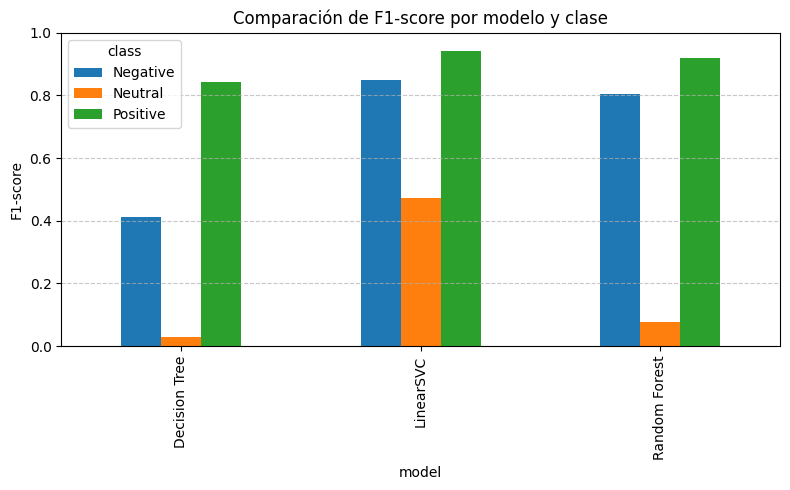

In [26]:
pivot_f1 = summary_all.pivot(index='model', columns='class', values='f1-score')
print(pivot_f1)

pivot_f1.plot(kind='bar')
plt.title('Comparación de F1-score por modelo y clase')
plt.ylabel('F1-score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 🧾 Conclusiones finales (multiclase, reseñas de teléfonos móviles)

- El flujo implementado permite clasificar reseñas de teléfonos móviles en **tres categorías de sentimiento**: *Negative* (rating ≤ 2), *Neutral* (rating = 3) y *Positive* (rating > 3), usando modelos de aprendizaje supervisado.  
- La representación de texto mediante **TF-IDF con stopwords en inglés** resulta adecuada para este tipo de reseñas y ayuda a reducir ruido al eliminar palabras muy frecuentes sin carga semántica relevante.  
- Es habitual que los modelos presenten mejor desempeño en reseñas claramente positivas o negativas, mientras que las reseñas neutrales tienden a ser más difíciles de clasificar debido a su ambigüedad.  
- Entre los modelos probados, el **SVM lineal (LinearSVC)** suele ofrecer el mejor equilibrio entre precisión y recall en problemas de texto de alta dimensión, mientras que Random Forest y Decision Tree aportan interpretabilidad y alternativas no lineales.  

Como trabajo futuro, se podrían explorar modelos basados en redes neuronales (por ejemplo, LSTM o modelos preentrenados como BERT) para capturar mejor la semántica de las reseñas y mejorar la clasificación de sentimientos neutrales.